<a href="https://colab.research.google.com/github/sagars729/HooHacks20/blob/master/HooHacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Confirmed Covid-19 Cases
This notebook attempts to predict the spread of Covid-19 in the United States. We use a time forecasting Multilayer Perceptron Model to estimate the number of cases that will occur in an area in the next day based on 

* Number of cases in the past three days
* Popultion desnity of the area
* Age Distribution of the population   



## Data
The code blocks below clones the SQLite database from our GitHub repository and opens the database using sqlite3. 

In [63]:
!rm -rf HooHacks20/
!rm -rf ckpts/
!git clone https://github.com/sagars729/HooHacks20.git
!mkdir ckpts

Cloning into 'HooHacks20'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [112]:
import sqlite3 as sql

def init():
	conn = sql.connect("HooHacks20/covid.db")
	curs = conn.cursor()
	return conn, curs

def close():
	conn.commit()
	conn.close()

conn, curs = init()
num_rows = [r[0] for r in conn.execute("select count(*) from mytable")][0]
print("Covid-19 dataset loaded with %d rows" % num_rows)

locs = [r[0] for r in conn.execute("select distinct location from mytable")]
print("%d Distinct Locations in Dataset" % len(locs))

dense = [r[0] for r in conn.execute("select distinct density from mytable order by density")]
max_dense = dense[len(dense) - 2]

Covid-19 dataset loaded with 1361 rows
52 Distinct Locations in Dataset


## Preprocessing Data

Data for each location is split into three day sliding windows that represent the number of cases in that three day period. All other variables (population density, age distribution) remain constant throughout a location's data. 

Density data is normalized by dividing by the maximum density in the dataset. Age distriution data is represented as percentiles and therfore already normalized.

The entire collection of data is shuffled and split into training, testing, and validation datasets (70-15-15 split)

In [113]:
from datetime import datetime
import numpy as np
from math import log

X = []
Y = []
P = []

nd = lambda d: 1 if d > max_dense else d/max_dense

def date_to_tup(dstr):
  d = [int(i) for i in dstr.split("/")]
  return (d[2], d[0], d[1])

def generate_sequences(seq=3):
  for loc in locs:
    res = conn.execute("select date, cases, population, density, children_018, adults_1925, adults_2634, adults_3554, adults_5564, adults_65pl from mytable where location=?", (loc,))
    res = [r for r in res]
    res.sort(key=lambda r: date_to_tup(r[0]))
    cases = [r[1] for r in res]

    data = [nd(res[0][3])] + [float(v) for v in res[0][4:]]
    for i in range(seq, len(cases)):
      X.append(cases[i-seq:i] + data)
      Y.append([cases[i]])
      P.append(res[0][2])

#Get data in sequences of 3
generate_sequences(3)
conn.close()
X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="float32")
P = np.array(P, dtype="float32")
#print(X,Y)

#Shuffle the data
ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
Y = Y[ind]
P = P[ind]

#Partition Dataset
size = X.shape[0]
X_train = X[:int(.7*size)]
X_test = X[int(.7*size):int(.85*size)]
X_val = X[int(.85*size):]
Y_train = Y[:int(.7*size)]
Y_test = Y[int(.7*size):int(.85*size)]
Y_val = Y[int(.85*size):]
P_train = P[:int(.7*size)]
P_test = P[int(.7*size):int(.85*size)]
P_val = P[int(.85*size):]

print(X_train.shape, X_test.shape, X_val.shape)

(843, 10) (181, 10) (181, 10)


## Model

We created a Multilayer Perceptron Model with two fully connected layers of ten nodes each and one fuly connected layer with one node. The input to this model consists of the sliding window of the number of Covid19 Cases for the past 3 days followed by the population density an age distribution. 

The model was compiled to use the Adam optimizer and a Mean Squared Error Loss

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

def create_model(idim = X.shape[1]):
  model = Sequential()
  model.add(Dense(10, activation='relu', input_dim=idim))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  
  return model

The model was set to train for 500 epochs with callbacks checking to see if improvements were being made on the validation loss. Only the best model was saved and the training was stopped if the model did not improve validation loss over a set number of epochs

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot

# fit model
model = create_model()
history = model.fit(x=X_train, y=Y_train, batch_size=4, epochs=500, validation_data=(X_val, Y_val), verbose=1, shuffle=True, callbacks=
                              [ModelCheckpoint(filepath='ckpts/best_val_loss.hdf5',
                                               monitor='val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=0),
                               EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1)]) 

## Results

The loss over training and validation is plotted below.

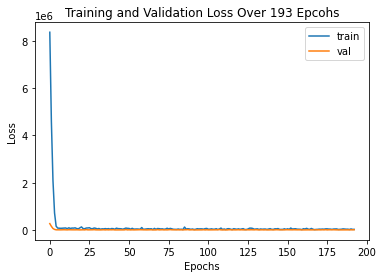

In [146]:
#plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epcohs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

The following code calculates the Root Mean Squared Error on the training, validation, and testing datasets using our model.

In [147]:
from sklearn.metrics import mean_squared_error
from math import sqrt

model = create_model()
model.load_weights("ckpts/best_val_loss.hdf5")

y_pred = model.predict(X_train)
mse = mean_squared_error(Y_train, y_pred)
print("Training RMSE: %d" % sqrt(mse))

y_pred = model.predict(X_val)
mse = mean_squared_error(Y_val, y_pred)
print("Validation RMSE: %d" % sqrt(mse))

y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print("Testing RMSE: %d" % sqrt(mse))

Training RMSE: 286
Validation RMSE: 50
Testing RMSE: 66


The following plots compare the predicted and real data for each state.  

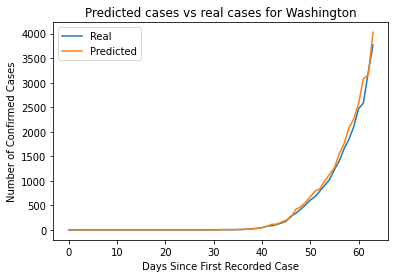

Mean Absolute Error: 87.5862612483959


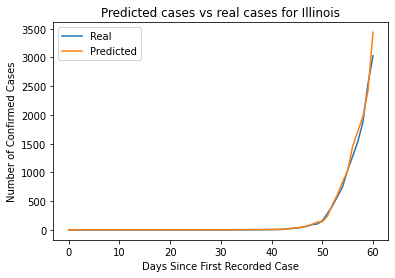

Mean Absolute Error: 66.54084942989975


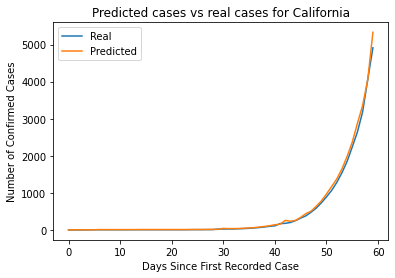

Mean Absolute Error: 76.23291411126965


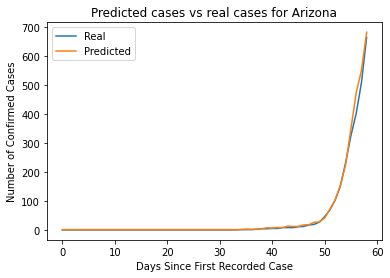

Mean Absolute Error: 11.75534812015721


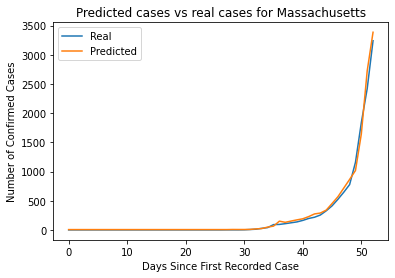

Mean Absolute Error: 61.651783808176475


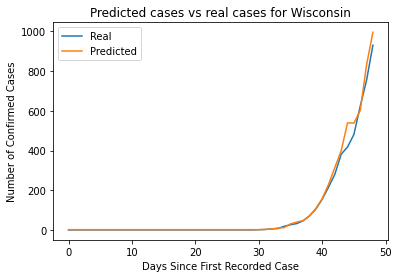

Mean Absolute Error: 25.001776550134235


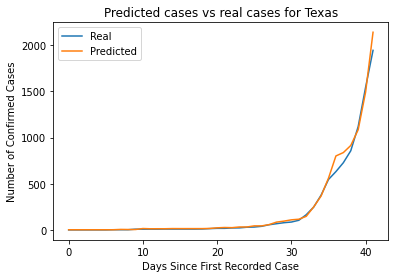

Mean Absolute Error: 45.909188072868886


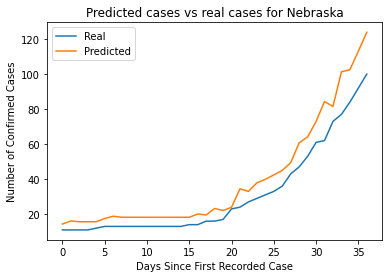

Mean Absolute Error: 10.401430234875447


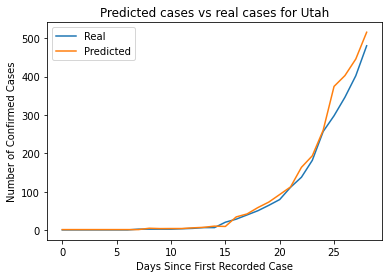

Mean Absolute Error: 21.53768244360016


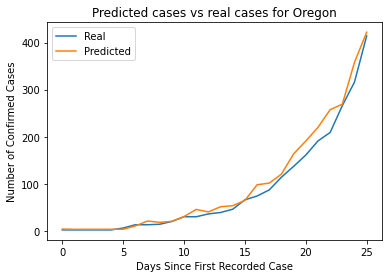

Mean Absolute Error: 17.546702923021613


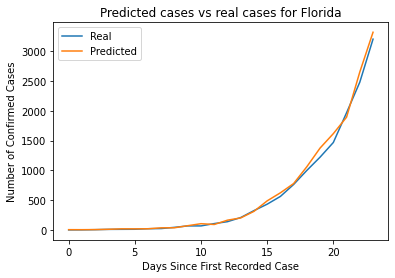

Mean Absolute Error: 66.65750799630439


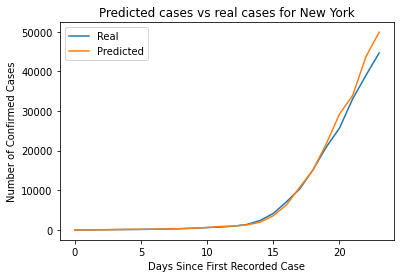

Mean Absolute Error: 1639.2288612314403


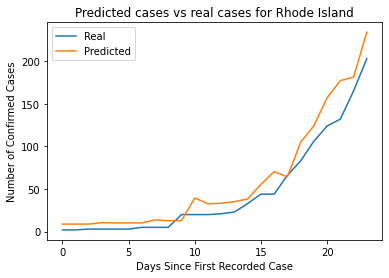

Mean Absolute Error: 17.53791353981971


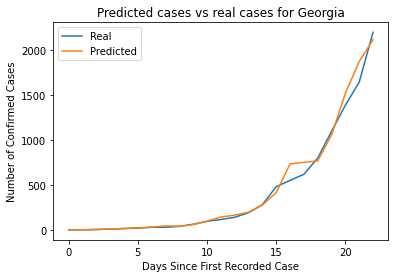

Mean Absolute Error: 77.16397221793018


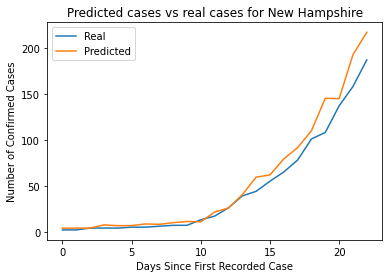

Mean Absolute Error: 13.820938240855774


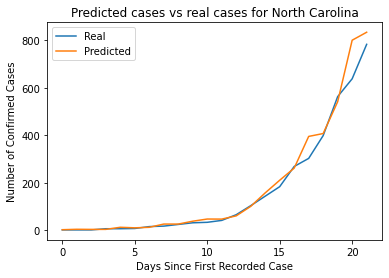

Mean Absolute Error: 42.358270373732665


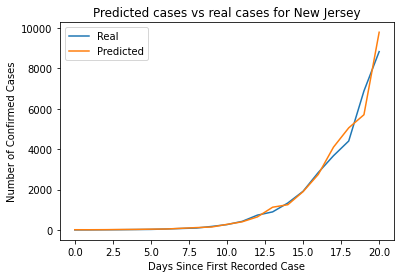

Mean Absolute Error: 376.6824948267572


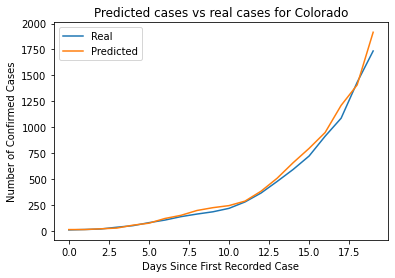

Mean Absolute Error: 56.957515993736045


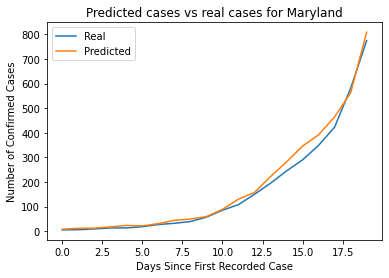

Mean Absolute Error: 23.77240836846909


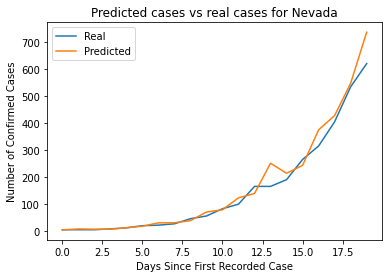

Mean Absolute Error: 37.43286362786628


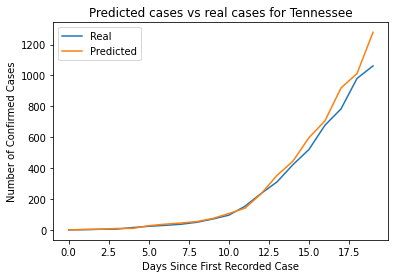

Mean Absolute Error: 61.58956621244596


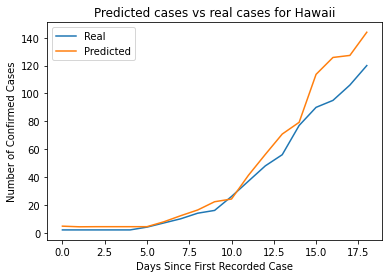

Mean Absolute Error: 12.415097603563158


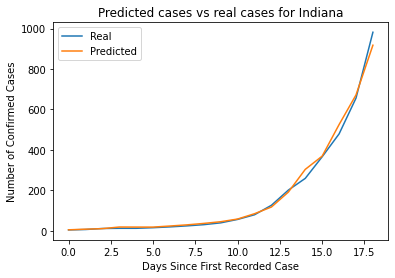

Mean Absolute Error: 21.646074974130357


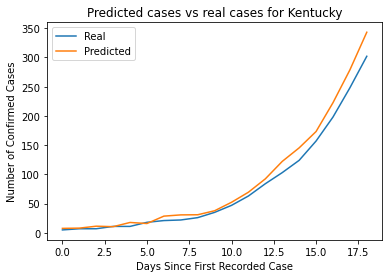

Mean Absolute Error: 15.725943558293526


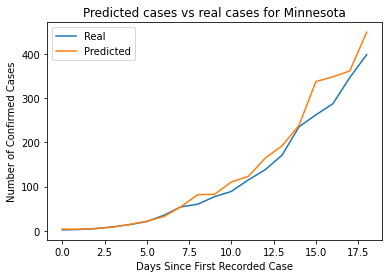

Mean Absolute Error: 27.46301473174443


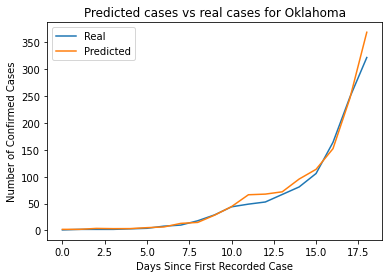

Mean Absolute Error: 12.992049839942506


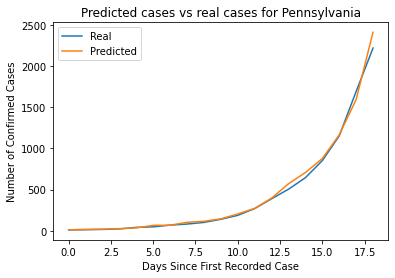

Mean Absolute Error: 54.717026575572845


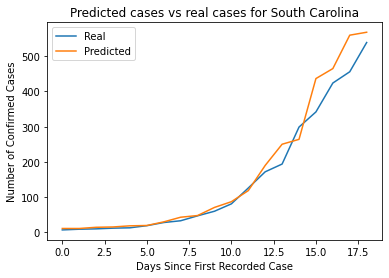

Mean Absolute Error: 37.974823563586305


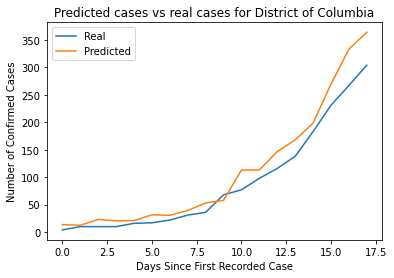

Mean Absolute Error: 28.09044720063452


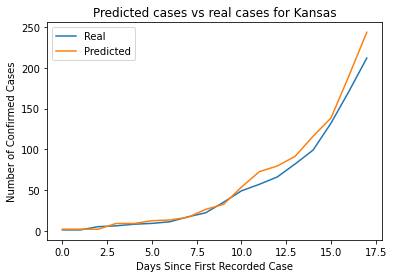

Mean Absolute Error: 11.270303286336954


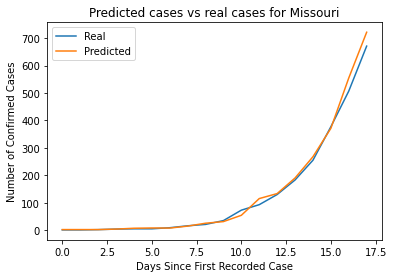

Mean Absolute Error: 18.256821010792244


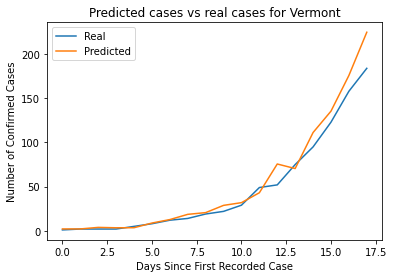

Mean Absolute Error: 13.150666305641794


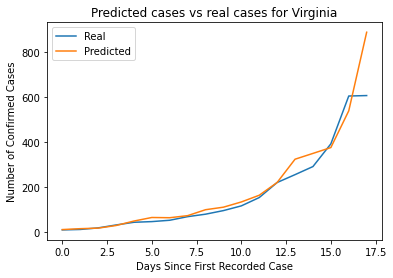

Mean Absolute Error: 72.17346745235682


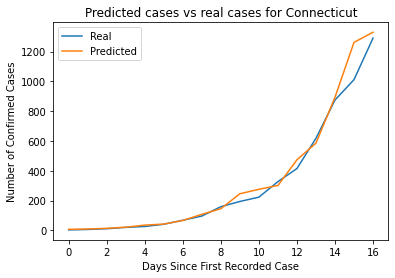

Mean Absolute Error: 66.67082683278868


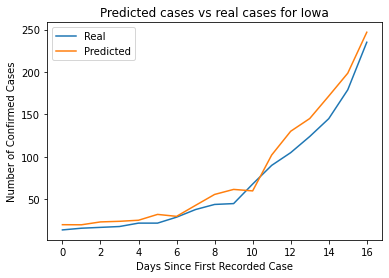

Mean Absolute Error: 13.760110448429545


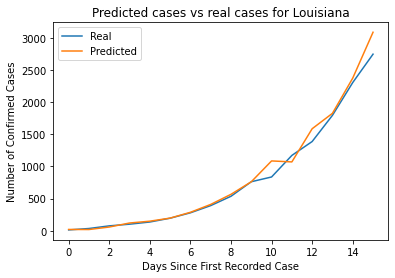

Mean Absolute Error: 121.49595124255445


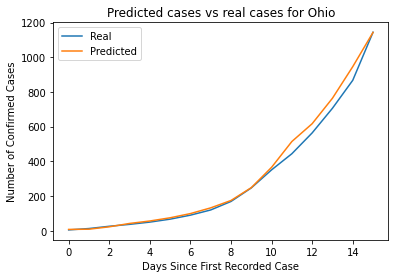

Mean Absolute Error: 33.4752952177926


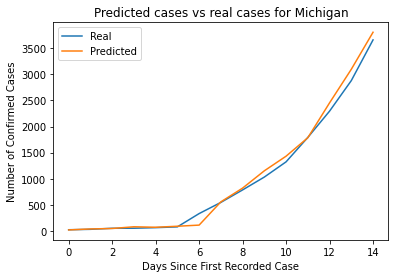

Mean Absolute Error: 106.58144083549006


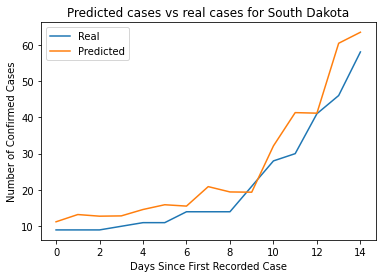

Mean Absolute Error: 6.037036115696809


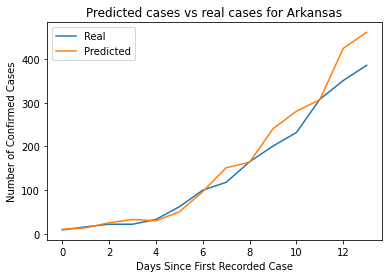

Mean Absolute Error: 34.31617188730418


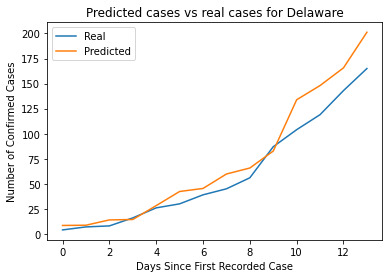

Mean Absolute Error: 17.219622246015838


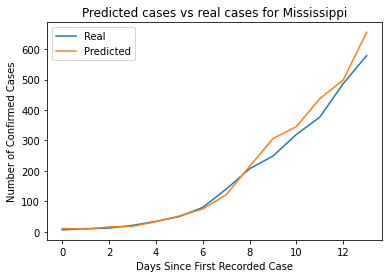

Mean Absolute Error: 31.882753283108585


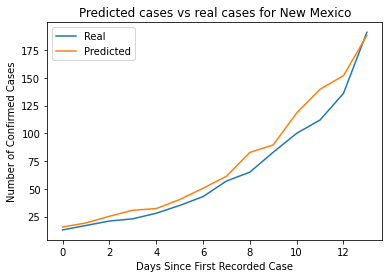

Mean Absolute Error: 11.74768874864728


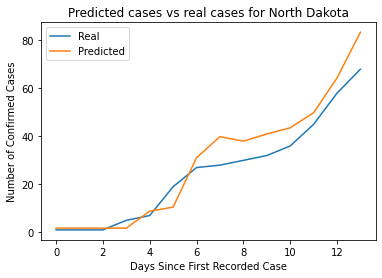

Mean Absolute Error: 7.311055636295241


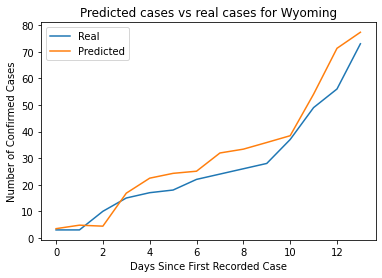

Mean Absolute Error: 6.417751621479823


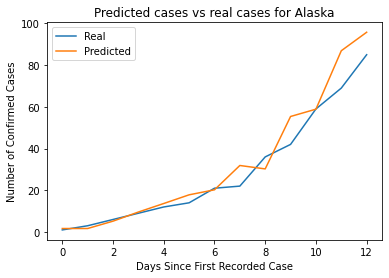

Mean Absolute Error: 7.68602070661627


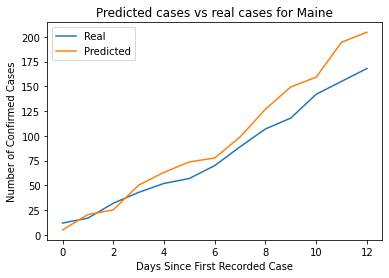

Mean Absolute Error: 20.205739116883144


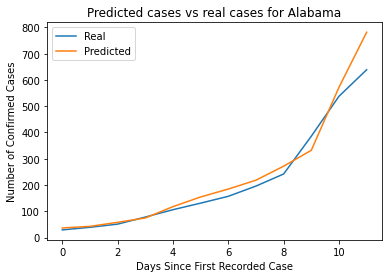

Mean Absolute Error: 47.79683939591436


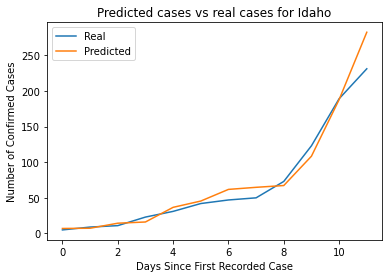

Mean Absolute Error: 16.889237691333065


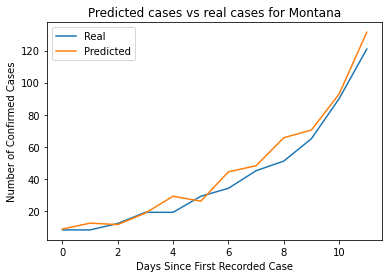

Mean Absolute Error: 7.102514303818289


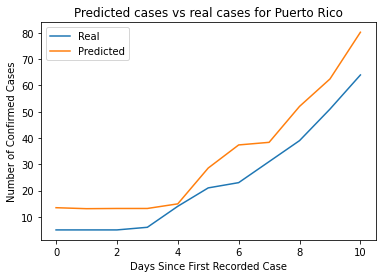

Mean Absolute Error: 10.17707962655473


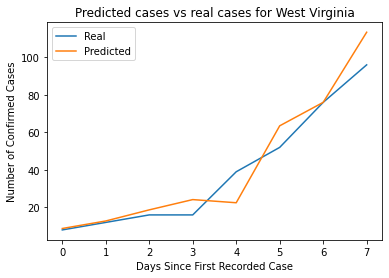

Mean Absolute Error: 9.88850310498488


In [148]:
conn, curs = init()

for loc in locs:
  x = []
  y = []
  res = conn.execute("select date, cases, population, density, children_018, adults_1925, adults_2634, adults_3554, adults_5564, adults_65pl from mytable where location=?", (loc,))
  res = [r for r in res]
  res.sort(key=lambda r: date_to_tup(r[0]))
  cases = [r[1] for r in res]

  data = [nd(res[0][3])] + [float(v) for v in res[0][4:]]
  for i in range(seq, len(cases)):
    x.append(cases[i-seq:i] + data)
    y.append([cases[i]])

  x = np.array(x, dtype="float32")
  y_pred = model.predict(x)
  pyplot.plot([i[0] for i in y], label="Real")
  pyplot.plot([i[0] for i in y_pred], label="Predicted")
  pyplot.title("Predicted cases vs real cases for %s" % (loc,))
  pyplot.xlabel("Days Since First Recorded Case")
  pyplot.ylabel("Number of Confirmed Cases")
  pyplot.legend()
  pyplot.show()

  print("Mean Absolute Error:", sqrt(mean_squared_error(y, y_pred)))